# Optimising functions

Now for something a bit different.
PyTorch is a tensor processing library and whilst it has a focus on neural networks, it can also be used for more standard funciton optimisation.
In this example we will use torchbearer to minimise a simple function.

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. We recommend you enable a free GPU with

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

## Dependencies

First we install torchbearer if needed. 

In [1]:
try:
    import torchbearer
except:
    !pip install -q torchbearer
    import torchbearer
    
print(torchbearer.__version__)

0.3.2


## A Simple Function

For this task, we are going to try to optimise the following:

\begin{equation}
min_{\textbf{x}} (\textbf{x}[0] - 5)^2 + \textbf{x}[1]^2 + (\textbf{x}[2] - 1)^2\; ,
\end{equation}
which has a minimum at $\textbf{x}=[5, 0, 1]$.

### The Model

First we will need to create something that looks very similar to a neural network model - but with the purpose of minimising our function.
We store the current estimates for the minimum as parameters in the model (so PyTorch optimisers can find and optimise them) and we return the function value in the forward method.

In [2]:
import torch
import torch.nn as nn

ESTIMATE = torchbearer.state_key('est')


class Net(nn.Module):
    def __init__(self, x):
        super().__init__()
        self.pars = nn.Parameter(x)

    def f(self):
        """
        function to be minimised:
        f(x) = (x[0]-5)^2 + x[1]^2 + (x[2]-1)^2
        Solution:
        x = [5,0,1]
        """
        out = torch.zeros_like(self.pars)
        out[0] = self.pars[0]-5
        out[1] = self.pars[1]
        out[2] = self.pars[2]-1
        return torch.sum(out**2)

    def forward(self, _, state):
        state[ESTIMATE] = self.pars.detach().unsqueeze(1)
        return self.f()

### The Loss

For function minimisation we have an analogue to neural network losses - we minimise the value of the function under the current estimates of the minimum.
Note that as we are using a base loss, torchbearer passes this the network output and the "label" (which is of no use here).


In [3]:
def loss(y_pred, y_true):
    return y_pred

### Optimising

We need two more things before we can start optimising with torchbearer.
We need our initial guess - which we've set to [2.0, 1.0, 10.0] and we need to tell torchbearer how "long" an epoch is - I.e. how many optimisation steps we want for each epoch.
For our simple function, we can complete the optimisation in a single epoch, but for more complex optimisations we might want to take multiple epochs and include tensorboard logging and perhaps learning rate annealing to find a final solution.

In [4]:
p = torch.tensor([2.0, 1.0, 10.0])
training_steps = 5000

The learning rate chosen for this example is very low and we could get convergence much faster with a larger rate, however this allows us to view convergence in real time.
We define the model and optimiser in the standard way.

In [5]:
model = Net(p)
optim = torch.optim.SGD(model.parameters(), lr=0.001)

Finally we start the optimising on the GPU and print the final minimum estimate.

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
trial = torchbearer.Trial(model, optim, loss, [torchbearer.metrics.running_mean(ESTIMATE, dim=1), 'loss'])
trial.for_train_steps(training_steps).to(device)
trial.run()
print(list(model.parameters())[0].data)


tensor([4.9999e+00, 4.4948e-05, 1.0004e+00], device='cuda:0')


## Visualising Himmelblau's Function

We'll now have a go at a more complex example, which we also visualise, with multiple optima; [Himmelblau's function](https://en.wikipedia.org/wiki/Himmelblau%27s_function). This is defined as:

\begin{equation}
f(x, y) = (x^2 + y - 11)^2 + (x + y^2 - 7)^2\; ,
\end{equation}
and has minima at
\begin{equation}
f(3, 2) = f(-2.805118, 3.131312) = f(-3.779310, -3.283186) = f(3.584428, -1.848126) = 0\; .
\end{equation}

Let's first define the function

In [7]:
himm = lambda x, y: (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2

and plot its surface

In [8]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm

xmin, xmax, xstep = -5, 5, .2
ymin, ymax, ystep = -5, 5, .2
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = himm(x, y)

fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)
ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

plt.show()

<Figure size 800x500 with 1 Axes>

That looks about right, now we'd like to view the optimisation path of a few different optimisers.

### The Model

Since we already have the function definition, we can define our model simply: 

In [9]:
import torch
import torch.nn as nn

ESTIMATE = torchbearer.state_key('est')

class Net(nn.Module):
    def __init__(self, x):
        super().__init__()
        self.pars = nn.Parameter(x)

    def forward(self, _, state):
        state[ESTIMATE] = self.pars.detach()
        return himm(self.pars[0], self.pars[1])

### Visualising

We now wish to create a visualisation. There are a few ways to do this, we'll use a couple of callback functions, combined in a [`CallbackList`](https://torchbearer.readthedocs.io/en/latest/code/callbacks.html#torchbearer.callbacks.callbacks.CallbackList).

In [10]:
import torchbearer
from torchbearer import callbacks

def make_callback(ax, color, label):
    xs = []
    ys = []
    
    @callbacks.on_step_training
    def log_estimate(state):
        est = state[torchbearer.METRICS][ESTIMATE].cpu().numpy()
        xs.append(est[0])
        ys.append(est[1])
    
    @callbacks.on_end
    def plot_history(state):
        ax.plot(xs, ys, color=color, label=label, linewidth=2)
    
    return callbacks.CallbackList([log_estimate, plot_history])

This callback will allow us to create an axis (2d this time) and subsequently plot the optimisation path on it for a series of optimisers.

### Optimising

Let's see how it looks for a few different optimisers from a range of starting points

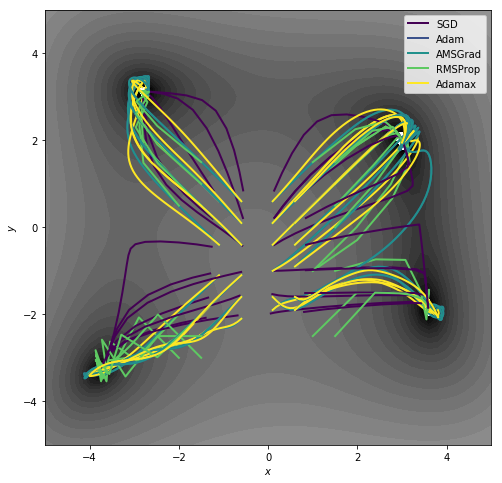

In [11]:
import numpy as np
import torchbearer
device = 'cuda' if torch.cuda.is_available() else 'cpu'

xmin, xmax, xstep = -5, 5, .2
ymin, ymax, ystep = -5, 5, .2
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = himm(x, y)

fig, ax = plt.subplots(figsize=(8, 8))
ax.contourf(x, y, z, levels=np.logspace(0, 5, 35), norm=LogNorm(), cmap=plt.cm.gray)

def make_plots(p):
    def run(optimiser, color, label):
        model = Net(p)
        optim = optimiser(model.parameters())
        training_steps = 50
        trial = torchbearer.Trial(model, optim, loss, [ESTIMATE], callbacks=[make_callback(ax, color, label)], verbose=-1)
        trial.for_train_steps(training_steps).to(device)
        trial.run()

    cmap = plt.cm.viridis

    run(lambda param: torch.optim.SGD(param, lr=0.01), cmap(0), 'SGD')
    run(lambda param: torch.optim.Adam(param, lr=0.1), cmap(0.25), 'Adam')
    run(lambda param: torch.optim.Adam(param, lr=0.1, amsgrad=True), cmap(0.5), 'AMSGrad')
    run(lambda param: torch.optim.RMSprop(param, lr=0.1), cmap(0.75), 'RMSProp')
    run(lambda param: torch.optim.Adamax(param, lr=0.1), cmap(1.0), 'Adamax')

make_plots(torch.tensor([0.0, 0.0]))
plt.legend()

for x in np.arange(-1.0, 1.0, 0.5):
    for y in np.arange(-2.0, 1.0, 0.5):
        make_plots(torch.tensor([x, y]))

ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))
        
fig.savefig('optimisers.png', bbox_inches='tight')